In [1]:
import cv2
import autograd.numpy as np
from autograd import grad
from scipy.signal import convolve2d
from scipy.sparse.linalg import bicg
from scipy.optimize import fmin_cg
from scipy.optimize import minimize
from importnb import Notebook
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy.fft as fft
import numpy.matlib
from skimage.transform import rotate
import sys
from tqdm import tqdm_notebook as tqdm
import sklearn
import sklearn.neighbors as neighbors

from scipy.sparse.linalg import LinearOperator
from scipy.sparse.linalg import aslinearoperator
import numpy as np
from scipy.sparse.linalg import bicg, bicgstab
from scipy.signal import convolve2d

# from sklearn.neighbors import LSHForest

In [2]:
with Notebook(): 
        import utils
        import pinkNoise
        import reblur

## patch recurence

In [17]:
def bkMat(K_mag, K_dir, patch_size=31):
    
    import time
    st = time.time()
    rows, cols = K_mag.shape
    out = np.zeros((patch_size*patch_size, rows*cols))
    index = 0
    for r in range(rows):
        for c in range(cols):
            print(r,c, end='\r')
            kernel = utils.blurKernel(int(K_mag[r,c]), K_dir[r,c])
            pd = patch_size - kernel.shape[0]
            kernel = np.pad(kernel, ((pd//2, pd-pd//2), (pd//2, pd-pd//2)), 'constant', constant_values=(0, 0))
            out[:,index] = kernel.ravel()
            index += 1
    en = time.time()
    print(en-st)
    return out

image ./resources/test4.png loaded
25.353910930723472



(300, 438)
[[11. 11. 11. ... 11. 11. 11.]
 [11. 11. 11. ... 11. 11. 11.]
 [11. 11. 11. ... 11. 11. 11.]
 ...
 [11. 11. 11. ... 11. 11. 11.]
 [11. 11. 11. ... 11. 11. 11.]
 [11. 11. 11. ... 11. 11. 11.]]


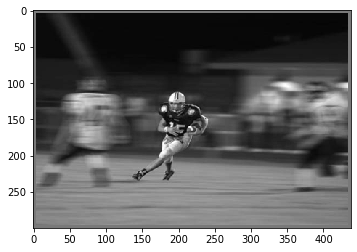

In [3]:
img = utils.loadImage('./resources/test4.png', 'gray')
noise, noised_img = pinkNoise.addNoise(img, exponent = -1)
magnitude, directions = reblur.getImageBlurEstimate(noised_img)
K_mat = bkMat(magnitude, directions, 31)
K_matrot = bkMat(magnitude, directions+180, 31)
x = img
print(x.shape)
plt.imshow(x, cmap='gray')
print(magnitude)

In [18]:
def downscale(x, alpha, show=False):
    '''
     @input x: blurred img x
     @input alpha: scaling factor 

     @return: downscaled image (x/alpha)
    '''
    downscaled_image = cv2.resize(x,None, fx=1/alpha,fy=1/alpha,interpolation=cv2.INTER_LANCZOS4)
    
    if show:
        plt.imshow(downscaled_image, cmap='gray')
        plt.figure()
        plt.imshow(x, cmap='gray')
        plt.show()
        downscaled_image.shape, x.shape
    
    return downscaled_image

In [35]:
from annoy import AnnoyIndex

class AnnoyKNN:
    def __init__(self, patch_size, method):
        self.patch_size = patch_size
        self.feature_dims = patch_size*patch_size
        self.KNN = AnnoyIndex(self.feature_dims, method)

    
    def make_index(self, img):
        """
            make indices to be used for search in KNN
            patches are flatten and treated as 1D vectors
        """
        img = utils.im2col(img, [self.patch_size, self.patch_size])
        for i in range(img.shape[1]):
            self.KNN.add_item(i, (img.T)[i,:])
            
    def build(self, n_trees):
        """
            specify the no. of trees to be used
            more trees -> higher accuracy, higher search time
        """
        self.KNN.build(n_trees)
        
    def get_nn(self, patch):
        """
            input patch to be searched
            returns the nearest patch from indices
        """
        nn = self.KNN.get_nns_by_vector(patch.flatten(), 1)
#         print(nn)
        nn = self.KNN.get_item_vector(nn[0])
        return (np.array(nn)).reshape((self.patch_size, self.patch_size))

In [36]:
"""
imrpove -> predict for the entire row at once, using njobs
intra image reccurence
"""

from annoy import AnnoyIndex
import random
import time


def getPriorPatch(patch, im_shape, cimg, h):
    k = patch.shape[0]
    
    num = np.zeros((k,k))
    denom = 0
    
    cpatch = patch.ravel()[:,None]
    
    prob = np.exp(-np.mean((cpatch - cimg)**2, axis=0)/(2*(h**2)))
    denom = np.sum(prob)
    num = cimg @ prob[:,None]
    num = num.reshape((k,k))
    
#     for i in range(k//2+1, n-k//2):
#         for j in range(k//2+1, m-k//2):
#             splice = img[i-k//2:i+k//2+1, j-k//2:j+k//2+1]
#             err = np.mean((patch - splice)**2)
#             exp = -err/(2*(h**2))
            
#             p = np.exp(exp)
#             num += p * splice
#             denom += p
            
    return num/(denom*k*k)

def getPrior(img, patch_size, alpha, h, stride):
    """
    @input img: size (n x m)
    @input patch_size
    @input alpha
    @input h
    @input stride: not used
    
    @return z: size (n x m)
    """
    
    start = time.time()
    M = patch_size
    x_alpha = downscale(img, alpha)
    n,m = img.shape
    
    KNN = AnnoyKNN(M, 'euclidean')
    KNN.make_index(x_alpha)
#     KNN.make_index(img)
    KNN.build(200)

    z = np.zeros(img.shape)
    
    for i in tqdm(range(M//2, n-M//2)):
        for j in range(M//2, m-M//2):
#             prior = predictions[:, (i-M//2)*(m-2*(M//2)) + (j-M//2)].reshape((M,M))/(M*M)
#             prior = getPriorPatch(patch, x_alpha.shape, cimg, h)
            z[i-M//2:i+M//2+1, j-M//2:j+M//2+1] += KNN.get_nn(img[i-M//2:i+M//2+1, j-M//2:j+M//2+1])/(M*M)
#             z[i-M//2:i+M//2+1, j-M//2:j+M//2+1] += (np.array(prior)).reshape((M,M))/(M*M)
    
    end = time.time()
    print('time taken:', end-start)
    
    return z

In [37]:
z = getPrior(x, 21, 4/3, 10, 1)

/envs/bluring/lib/python3.7/site-packages/ipykernel_launcher.py:59: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



time taken: 51.56568241119385


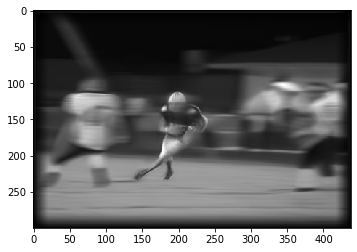

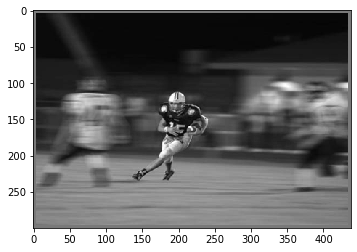

In [38]:
plt.imshow(z, cmap='gray')
plt.show()
plt.imshow(x, cmap='gray')

In [ ]:
K_mat = bkMat(magnitude, directions)
K_matrot = bkMat(magnitude, directions+180)

In [47]:
ss = img.shape
b = np.ones(ss).ravel()
beta = 10

itera = 1
noiseSD = 0.01
patchSize = 11
alpha = 4/3
betas = 50*np.array([1])
T = 10
h = 10
stride = 1
K=cv2.getGaussianKernel(5,1)
K = K@K.T
lam = 64/(noiseSD**2)
noiseI = np.float32(x)

def call_func(x):
    global ss, K, b, magnitude, directions
    img = x.reshape(ss)
    outp = myConvolve(img, K_mat)
    outp = myConvolve(outp, K_matrot)

    cost = np.mean(np.power(outp.ravel() - b, 2))
    global itera
    
    print("      Iter ->     ", itera, ' cost -- > ', cost)
    itera += 1

# def myConvolve(img, K_mag, K_dir, patch_size=30):
#     outp = np.zeros(img.shape)
#     pd = patch_size // 2
#     img = np.pad(img, ((pd, pd), (pd, pd)), 'reflect')
    
#     for i in range(pd, img.shape[0]-pd):
#         for j in range(pd, img.shape[1]-pd):
#             kernel = utils.blurKernel(int(K_mag[i-pd, j-pd]), K_dir[i-pd, j-pd])
#             kx, ky = kernel.shape
#             kernel=kernel.ravel()[:,None]
            
#             patch = img[i-kx//2:i+kx//2, j-ky//2:j+ky//2].ravel()[:,None]
#             o = np.sum(patch * kernel)
# #             o = utils.linearBlur(img[:i+pd,j-pd:j+pd], int(K_mag[i-pd, j-pd]), K_dir[i-pd, j-pd])[15,15]
#             outp[i-pd,j-pd] = o
            
#     return outp
    
def myConvolve(img, kernel_matrix, patch_size=31):
    outp = np.zeros(img.shape)
    pd = patch_size // 2
    img_shape = img.shape
    img = np.pad(img, ((pd, pd), (pd, pd)), 'reflect')
    outp = np.sum(utils.im2col(img, [patch_size, patch_size]) * kernel_matrix, axis = 0)
            
    return outp.reshape(img_shape)
    
def make_mv(x, k_mag, k_dir, ss, lam, beta, patch_size = 30):
    def mv(x):
        K_mag = magnitude
        K_dir = directions
        img = x.reshape(ss)
        outp = myConvolve(img, K_mat)

#         K_dir = K_dir + 180

        foutp = myConvolve(outp, K_matrot)
        foutp *= lam
        return foutp.ravel() + beta*x
    return mv


func = make_mv(x, magnitude, directions, ss, lam, beta)
A = LinearOperator((ss[0]*ss[1], ss[0]*ss[1]), matvec=func, rmatvec=func)

In [56]:
# plt.imshow(, cmap = 'gray')
# plt.show()
# plt.imshow(, cmap = 'gray')
# plt.show()
print(np.sum(myConvolve(img, K_mat)-myConvolve(img, K_matrot)))

2.591326264678173e-09


In [51]:
from scipy.optimize import fmin_bfgs

def EPLLhalfQuadraticSplitDeblur(noiseI, lam, K, patchSize, betas, T, alpha, h, stride):
    global z, x, A, beta
    beta = np.abs(betas[0]/4)
    cleanI = noiseI
    for betaa in betas:
        beta = betaa
        for tt in range(T):
            print("Iteration -> ", tt)
            I1 = z
            tt1 = noiseI
#             I1 = getPrior(cleanI, patchSize, alpha, h, stride)
#             tt1 = noiseI[(K.shape[0]//2):-(K.shape[0]//2),(K.shape[1]//2):-(K.shape[1]//2)]
#             tt1 = convolve2d(tt1, np.rot90(np.rot90(K)), 'full')
            tt1 = myConvolve(tt1, K_matrot)
            tt2 = I1
            x0 = I1.ravel()
            cleanI = bicgstab(A, lam*tt1.ravel() + beta*tt2.ravel(), x0 = x0, callback=call_func, maxiter=10)
            cleanI = np.reshape(cleanI[0], noiseI.shape)
            arr = plt.subplots(1,3, figsize = (15,15))[1]
            arr[0].imshow(z, cmap='gray')
            arr[1].imshow(x, cmap='gray')
            arr[2].imshow(cleanI, cmap='gray')
            
#             print(np.sum(cleanI-z), np.sum(z), np.sum(cleanI[30:-30,30:-30]-x[30:-30,30:-30]))
    return cleanI

Iteration ->  0
      Iter ->      36  cost -- >  9224.424281908588
      Iter ->      37  cost -- >  9248.249513183719
      Iter ->      38  cost -- >  9253.967752061992
      Iter ->      39  cost -- >  9259.676760529845
      Iter ->      40  cost -- >  9261.411522155493
      Iter ->      41  cost -- >  9268.265442313128
      Iter ->      42  cost -- >  9269.340900476436
      Iter ->      43  cost -- >  9268.77216955945
      Iter ->      44  cost -- >  9267.66654485701
      Iter ->      45  cost -- >  9266.761276269615


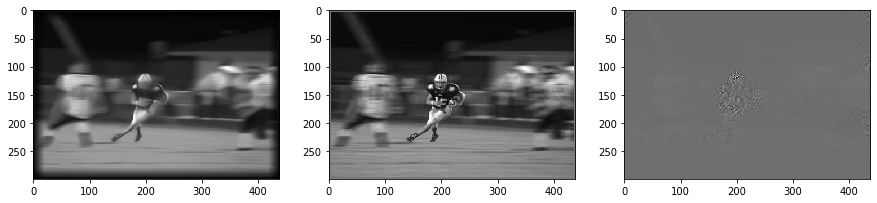

In [52]:

cleanI = EPLLhalfQuadraticSplitDeblur(noiseI, lam, K, patchSize, betas, 1, alpha, h, stride)

In [46]:
cleanI

array([[ -1747.29538761,  -1500.8546557 ,    721.3171829 , ...,
           851.91940582,   -749.370478  ,   1188.11531592],
       [ -7091.13926698,  -6744.94338394,  -1984.61821063, ...,
           617.70735944,  -2546.00631365,   -406.72910474],
       [-23308.3191376 , -23606.80023289,  -8583.43951926, ...,
           180.58171484, -10157.01236914,  -7228.84131208],
       ...,
       [   384.09169582,    303.80995369,    229.73210567, ...,
           122.04630765,    121.97586192,    121.83166943],
       [   287.48039265,     29.43584092,   -155.53382271, ...,
           122.04601404,    122.00022826,    121.90388735],
       [   196.78775464,   -158.65456032,   -415.55040544, ...,
           122.04212196,    122.01946335,    121.97160825]])

In [ ]:
K = [[2, 1], [1, 1]]
ss = (2, 2)
def mv(x):
    global K, ss
    img = x.reshape(ss)
    print(img)
    outp = convolve2d(img, K, 'same')
    outp = convolve2d(img, K, 'same')
    return outp.ravel()

A = LinearOperator((ss[0]*ss[1], ss[0]*ss[1]), matvec=mv, rmatvec=mv)

x = convolve2d(inp, K, 'same')
x = convolve2d(x, K, 'same')
b = x.ravel()

bicg(A, b)

In [ ]:
# K=cv2.getGaussianKernel(5,1)
# K = K@K.T
# ss = img.shape
# itera = 1
# b = np.ones(ss).ravel()
# def call_func(x):
#     global ss, K, b
#     img = x.reshape(ss)
#     outp = convolve2d(img, K, 'same')
#     cost = np.mean(np.power(outp.ravel() - b, 2))
#     global itera
#     print("      Iter ->     ", itera, "cost->       ", cost)
#     itera += 1
    
# def mv(x):
#     global ss, K
#     img = x.reshape(ss)
#     outp = convolve2d(img, K, 'same')
#     return outp.ravel()

# A = LinearOperator((ss[0]*ss[1], ss[0]*ss[1]), matvec=mv, rmatvec=mv)

# x0 = np.zeros(ss).ravel()

# # x = bicg(A, b, x0, callback=call_func, maxiter=100)

In [ ]:
def f(a,b):
    def g():
        print(a, b)
    return g
kk = f(1,2)

In [13]:
outputt = bkMat(magnitude, directions, 31)
print(outputt.shape)

50.95846366882324
(961, 131400)


In [6]:
print(np.round(10*outputt[:,11].reshape((11,11))), directions[0,11])
# print(np.round(utils.blurKernel(10,90)*10))


[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]] 90.0


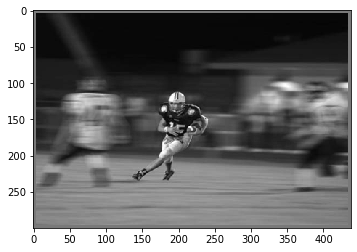

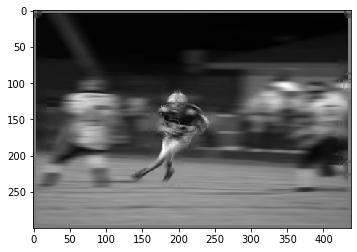

In [15]:
o = myConvolve(x, magnitude, directions)
plt.imshow(img, cmap='gray')
plt.show()
plt.imshow(o, cmap='gray')

In [11]:
utils.im2col(np.pad(img, ((5, 5), (5, 5)), 'reflect'), [11, 11]).shape

(121, 131400)